In [1]:
import cv2
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Trained Model

In [3]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor.fc = nn.Identity()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, image1, image2):
        features1 = self.feature_extractor(image1)
        features2 = self.feature_extractor(image2)
        diff = torch.abs(features1 - features2)
        x = torch.relu(self.fc1(diff))
        output = torch.sigmoid(self.fc2(x))
        return output

# Function to load the trained model
def load_siamese_model(file_path, model, optimizer=None, device='cpu'):
    checkpoint = torch.load(file_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    print(f"Model loaded from {file_path}")
    return model

## Dataset Preparation

In [4]:
# Dataset class for handling TCI image pairs
class BalancedTCIImagePairDataset(Dataset):
    def __init__(self, tci_tile_folders, transform=None):
        self.tci_tile_folders = tci_tile_folders
        self.transform = transform
        self.full_tci_images = [reconstruct_full_image_from_tiles_in_memory(folder) for folder in tci_tile_folders]
        self.pairs = self._create_balanced_pairs()

    def _create_balanced_pairs(self):
        pairs = []
        num_images = len(self.full_tci_images)
        for i in range(num_images):
            img1 = self.full_tci_images[i]
            img2 = img1
            pairs.append((img1, img2, 1))

        for i in range(num_images):
            img1 = self.full_tci_images[i]
            img2 = random.choice(self.full_tci_images)
            while np.array_equal(img2, img1):
                img2 = random.choice(self.full_tci_images)
            pairs.append((img1, img2, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1, img2, label = self.pairs[idx]
        img1 = Image.fromarray(img1)
        img2 = Image.fromarray(img2)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)

# Function to reconstruct full TCI image from tiles in memory
def reconstruct_full_image_from_tiles_in_memory(tile_dir, tile_size=512):
    tile_files = [f for f in os.listdir(tile_dir) if f.endswith('.jpg')]
    tile_files.sort(key=lambda f: (int(f.split('_')[-2]), int(f.split('_')[-1].replace('.jpg', ''))))

    max_y = max(int(f.split('_')[-2]) for f in tile_files)
    max_x = max(int(f.split('_')[-1].replace('.jpg', '')) for f in tile_files)
    full_height = max_y + tile_size
    full_width = max_x + tile_size

    full_image = np.zeros((full_height, full_width, 3), dtype=np.uint8)
    for tile_file in tile_files:
        y = int(tile_file.split('_')[-2])
        x = int(tile_file.split('_')[-1].replace('.jpg', ''))

        tile_path = os.path.join(tile_dir, tile_file)
        tile = cv2.imread(tile_path)

        full_image[y:y + tile_size, x:x + tile_size] = tile

    return full_image

In [5]:
# Load TCI image folders
root_dir = '/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data'

def get_tci_tile_folders(root_dir):
    tci_folders = []

    for root, dirs, files in os.walk(root_dir):
        if any('TCI' in file and file.endswith('.jpg') for file in files):
            tci_folders.append(root)

    return tci_folders

tci_tile_folders = get_tci_tile_folders(root_dir)

# Prepare the test dataset
_, test_tci_folders = train_test_split(tci_tile_folders, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = BalancedTCIImagePairDataset(test_tci_folders, transform=transform)

## Inference and Visualization

In [6]:
# Function to visualize a pair of images with keypoints
def visualize_image_pair_with_keypoints(model, img1, img2, device, sift, num_matches_to_draw=15):
    model.eval()
    if isinstance(img1, (Image.Image, np.ndarray)):
        img1_np = np.array(img1) if isinstance(img1, Image.Image) else img1
        img1 = transform(img1).unsqueeze(0).to(device)
    else:
        img1_np = img1.cpu().numpy().transpose(1, 2, 0)
        img1 = img1.unsqueeze(0).to(device)

    if isinstance(img2, (Image.Image, np.ndarray)):
        img2_np = np.array(img2) if isinstance(img2, Image.Image) else img2
        img2 = transform(img2).unsqueeze(0).to(device)
    else:
        img2_np = img2.cpu().numpy().transpose(1, 2, 0)
        img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        similarity_score = model(img1, img2).item()

    img1_np = (img1_np * 255).astype(np.uint8) if img1_np.max() <= 1 else img1_np
    img2_np = (img2_np * 255).astype(np.uint8) if img2_np.max() <= 1 else img2_np

    img1_np = cv2.cvtColor(img1_np, cv2.COLOR_BGR2RGB)
    img2_np = cv2.cvtColor(img2_np, cv2.COLOR_BGR2RGB)

    kp1, des1 = sift.detectAndCompute(img1_np, None)
    kp2, des2 = sift.detectAndCompute(img2_np, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    good_matches = sorted(good_matches, key=lambda x: x.distance)[:num_matches_to_draw]
    img_matches = cv2.drawMatches(img1_np, kp1, img2_np, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title(f'Similarity Score: {similarity_score:.4f}')
    plt.show()

# Test with some example pairs
def test_model_with_keypoints(model, dataset, device, num_examples=5, num_matches_to_draw=15):
    model.eval()
    for _ in range(num_examples):
        img1, img2, label = dataset[random.randint(0, len(dataset) - 1)]
        sift = cv2.SIFT_create()
        visualize_image_pair_with_keypoints(model, img1, img2, device, sift, num_matches_to_draw=num_matches_to_draw)

In [7]:
# Perform inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model = load_siamese_model('/content/drive/MyDrive/ Quantum DS Internship/Task 2/siamese_model.pth', model, device=device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]
<ipython-input-3-79518c5ccc69>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

Model loaded from /content/drive/MyDrive/ Quantum DS Internship/Task 2/siamese_model.pth


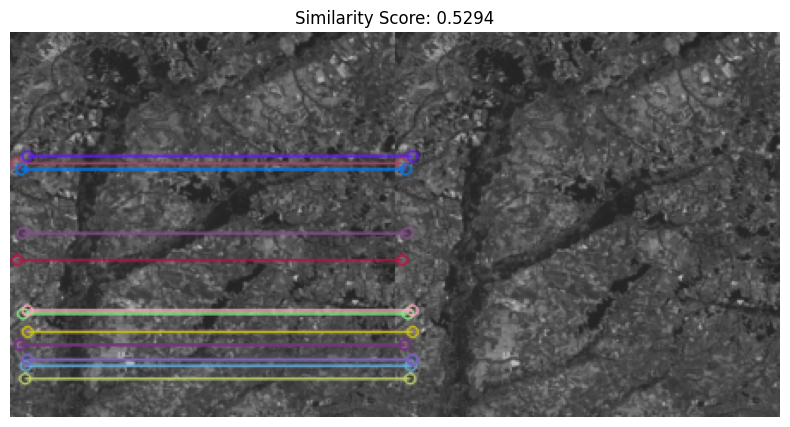

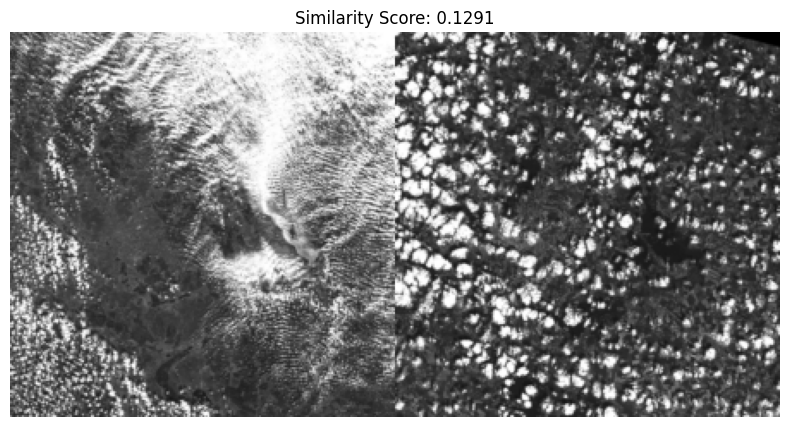

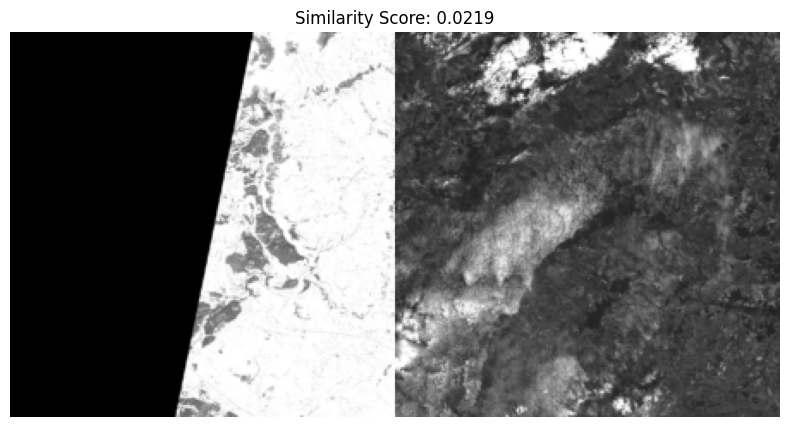

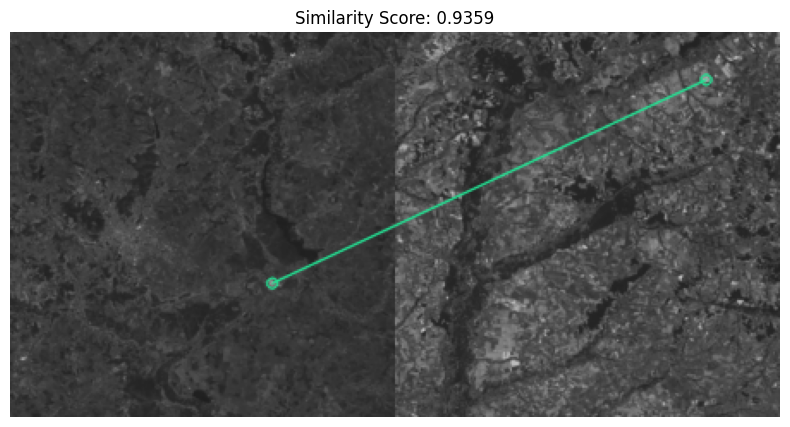

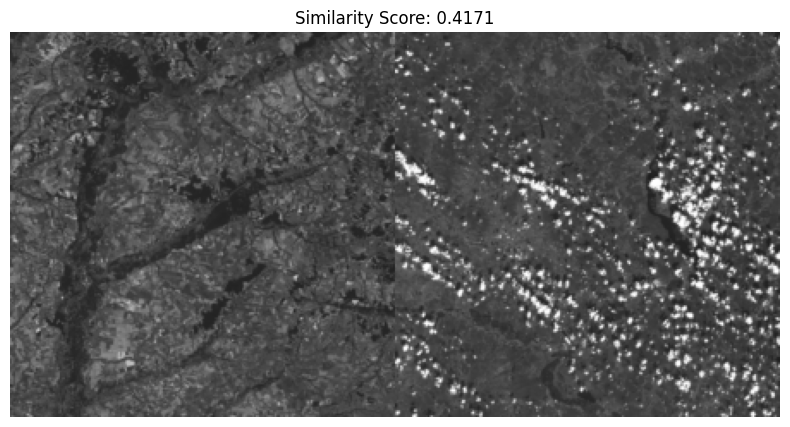

In [9]:
# Run inference on test data and visualize results
test_model_with_keypoints(model, test_dataset, device, num_examples=5, num_matches_to_draw=15)

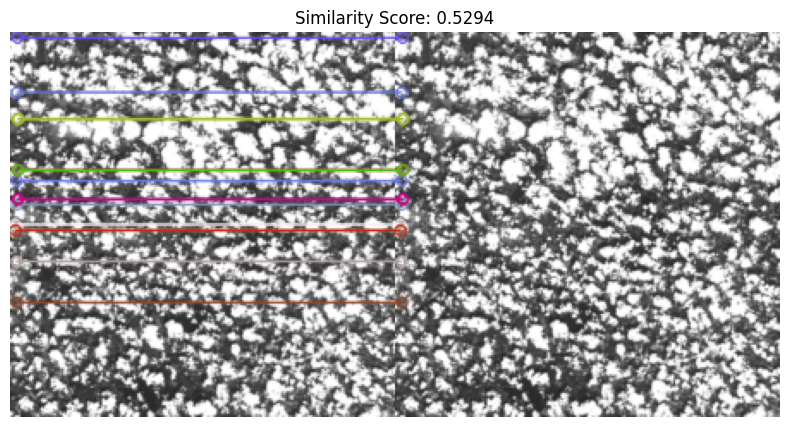

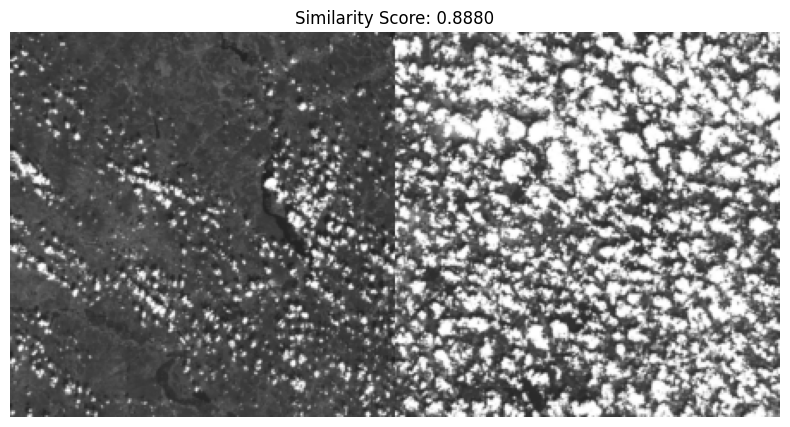

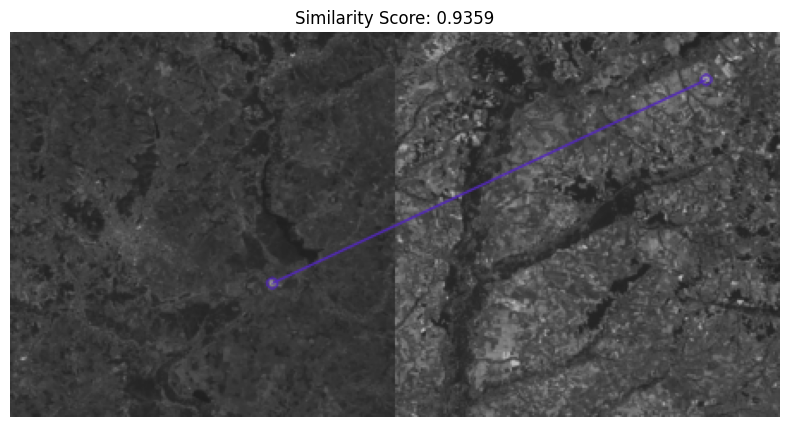

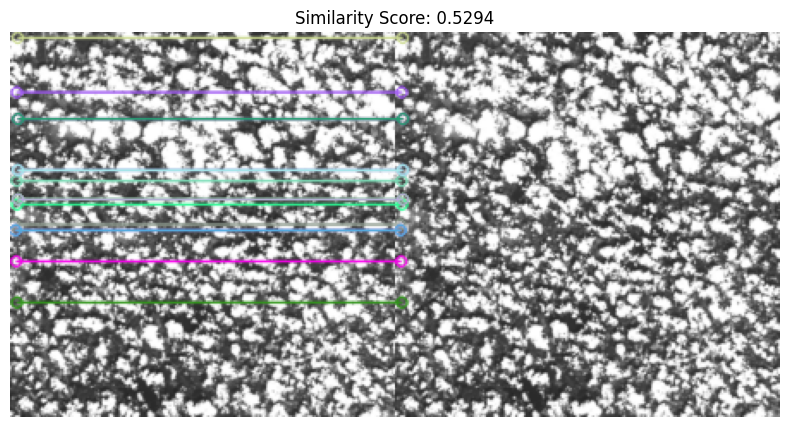

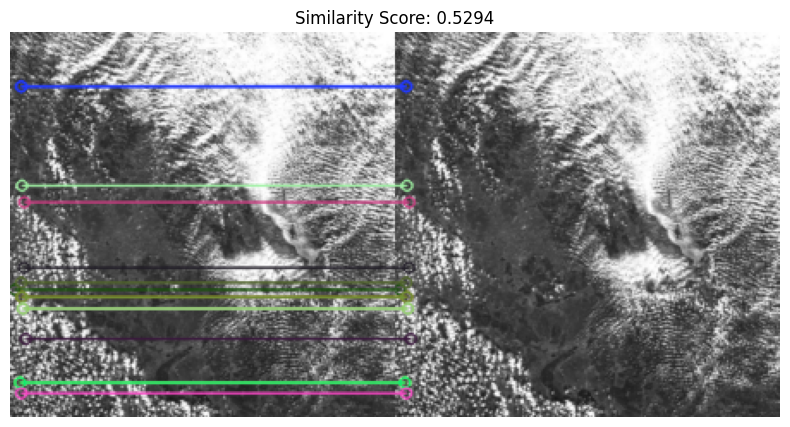

In [10]:
test_model_with_keypoints(model, test_dataset, device, num_examples=5, num_matches_to_draw=15)

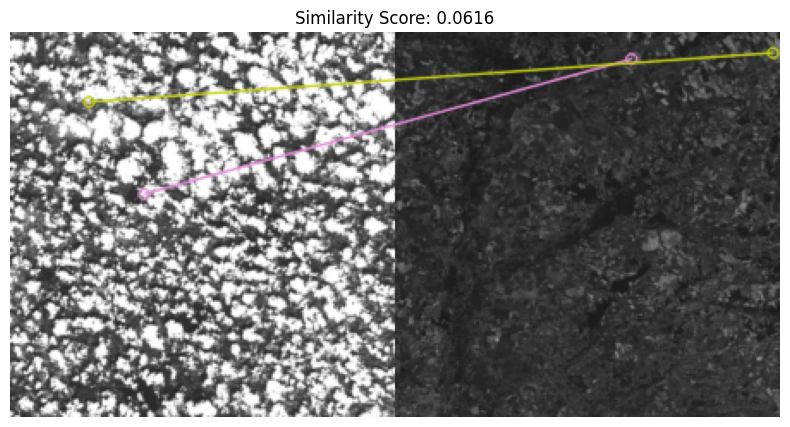

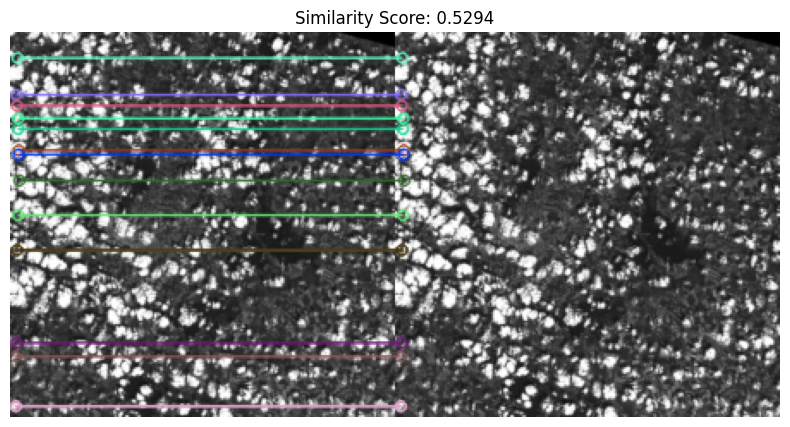

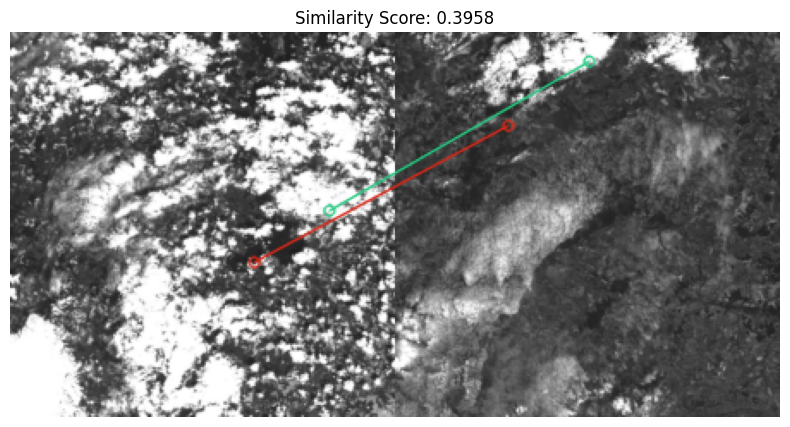

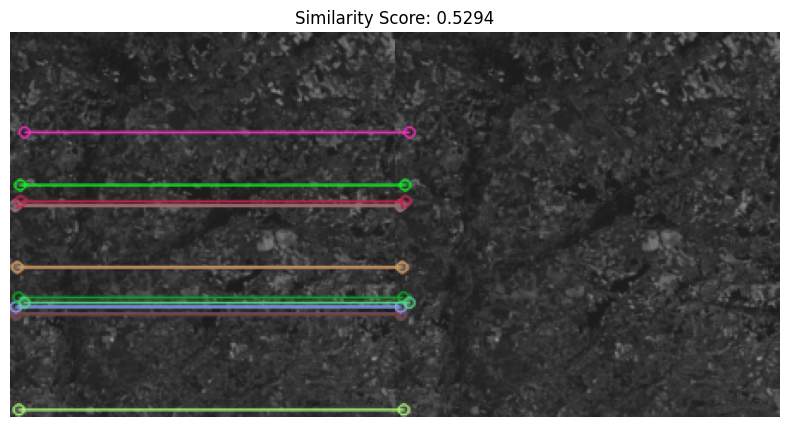

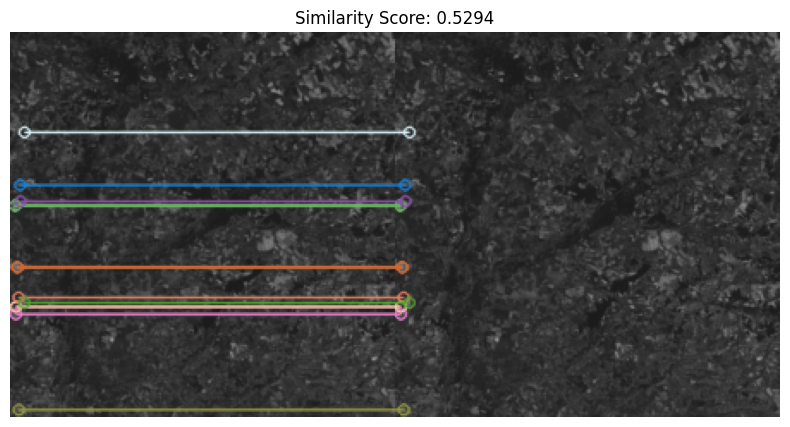

In [11]:
test_model_with_keypoints(model, test_dataset, device, num_examples=5, num_matches_to_draw=15)